# Test of the constant variance values using only feedforward layers

This notebook presents some tests of a feedforward neural network using the constant variance weight initialisation with a comparison to Xavier initialisation.

The conclusion from this notebook is that the initialisation does not make a significant difference to training time or final performance when the neural network is less than 10 layers deep.  This could be partially expected because at less than 10 layers on a simple dataset (or at least comparably simple dataset in computer vision), it is not difficult to train a neural network which performs reasonably, and it is likely a wide range of parameters would produce almost equivalent results.

Before running this notebook, run the `ActivationCoefficients.ipynb` notebook to generate the constant variance values.

In [1]:
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from PIL import Image, ImageDraw, ImageFont

import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize

import json
import matplotlib.pyplot as plt

import platform


torch.manual_seed(10)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

C:\Users\rmen2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


In [2]:
# This is tested on two datasets, the first is a basic dataset, the cancer dataset, the second it the Fashion MNIST dataset.
fashion_mnist_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST/',
    download=True,
    transform=Compose([
        ToTensor(),
        Lambda(lambda x: Normalize(torch.mean(x), torch.std(x), inplace=False)(x))
    ]))

# The dataset applied through the training transform
train_transform = Compose([
    torchvision.transforms.RandomHorizontalFlip(),
])

# The dataset applied through the validation transform
validation_transform = Compose([])

# Split the dataset into train and validation
# There are 70_000 samples total, so choose a 60_000/10_000 split, could also be 65_000/5_000 with little to no difference
fashionMNIST_dataset_train, fashionMNIST_dataset_validation = torch.utils.data.random_split(fashion_mnist_data, [55000, 5000])

# Create dataloaders
fashionMNIST_dataset_loader_train = torch.utils.data.DataLoader(fashionMNIST_dataset_train, batch_size=128, shuffle=True)
fashionMNIST_dataset_loader_validation = torch.utils.data.DataLoader(fashionMNIST_dataset_validation, batch_size=128, shuffle=False)

# Verify the data is normalised
print("Sample mean: " + str(torch.mean(fashion_mnist_data[1][0]).item()))
print("Sample std: " + str(torch.std(fashion_mnist_data[1][0]).item()))

Sample mean: 9.731370376186987e-09
Sample std: 0.9999999403953552


C:\Users\rmenzies\AppData\Local\Temp\ipykernel_13260\587701659.py:10: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  img_to_draw = img[0].convert("RGBA").resize((img[0].width*4, img[0].height*4), Image.BOX) #scale(4) 125


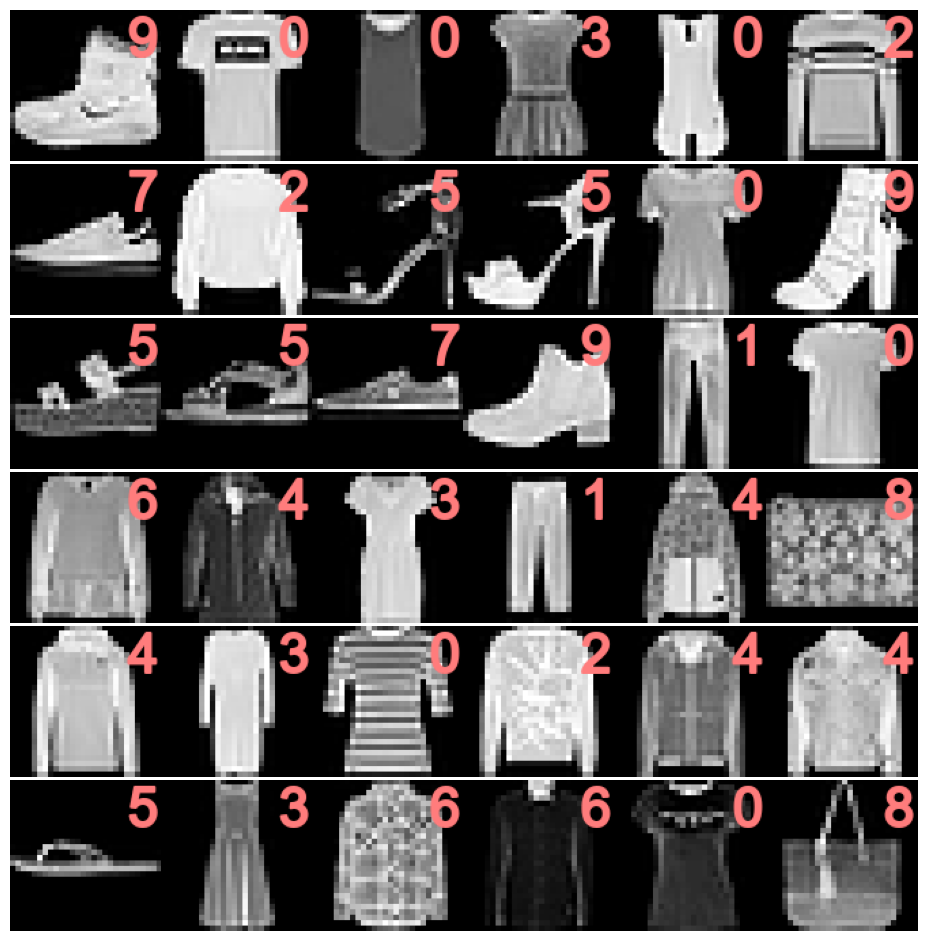

In [4]:
# Display some images from the FashionMNIST dataset, used in training the neural networks
fashion_mnist_data_display = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST/', download=False)

grid_size = 6

fig, axes = plt.subplots(grid_size, grid_size, figsize=(11.7, 12), gridspec_kw={"wspace":0, "hspace":0})

for (a, img) in zip(axes.flatten(), fashion_mnist_data_display):
    if platform.system() == "Windows":
        fnt = ImageFont.truetype("C:\Windows\Fonts\Arial.ttf", 40)
    img_to_draw = img[0].convert("RGBA").resize((img[0].width*4, img[0].height*4), Image.BOX) #scale(4) 125
    draw = ImageDraw.Draw(img_to_draw)
    draw.text((img_to_draw.size[0]-25, -2), str(img[1]), fill=(255, 70, 70, 180), font=fnt, stroke_width=1)
    a.imshow(img_to_draw, cmap="gray")
    a.set_axis_off()

fig.savefig("./FashionMNISTDatasetImg5.png")

del fashion_mnist_data_display

In [3]:
def get_accuracy(model, dataloader, device, transform):
    """ Determine the top-1 accuracy of the model using the data in the `dataloader` """
    model.eval()
    with torch.no_grad():
        acc_total = 0
        acc_len = 0
        for X,y in dataloader:
            acc_total += (torch.argmax(model(transform(X).to(device)), dim=1) == y.to(device)).int().sum()
            acc_len += len(y)
        final_acc = acc_total/acc_len
    model.train()
    return final_acc.item()


def training_loop(neural_net, optimizer, loss_fn, loss_arr=[], validation_acc_arr = [], collected_weights_std_arr=[], collected_weights_mean_arr=[]):
    """
    Run a training loop over all the data in the FashionMNIST dataset.
    This runs for a single epoch, put this in a loop to run multiple epochs.
    """
    for batch, (X, y) in enumerate(fashionMNIST_dataset_loader_train):
        pred = neural_net(X.to(device))
        loss = loss_fn(pred, y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 50 == 0:
            if batch % 200 == 0:
                print('\r', 'Loss:', str(loss.item()), end='                                ')

            valid_acc = get_accuracy(neural_net, fashionMNIST_dataset_loader_validation, "cuda", validation_transform)
            validation_acc_arr.append(valid_acc)

            loss_arr.append(loss.item())

            # Get the distribution of the weights, like in Xavier et Al.
            j = 0
            for p in neural_net.modules():
                if p.__class__.__name__ == "Linear":
                    collected_weights_std_arr[j].append(torch.std(p.weight).item())
                    collected_weights_mean_arr[j].append(torch.mean(p.weight).item())
                    j+=1


In [4]:
class NeuralNetworkActivationTest(nn.Module):
    """ A neural network which performs input normalisation through the initial weights """
    def __init__(self, activation):
        super(NeuralNetworkActivationTest, self).__init__()
        self.flatten = nn.Flatten()
        activation = activation()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            activation,
            nn.Linear(100, 58),
            activation,
            nn.Linear(58, 38),
            activation,
            nn.Linear(38, 28),
            activation,
            nn.Linear(28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits#

def test_activation_function_xavier(activation_function, learning_rate = 0.01, epochs = 30):
    """ Run a test for a specific activation function """
    print("Using activation function: " + str(activation_function))

    model = NeuralNetworkActivationTest(activation_function).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Initialise the weights using Xavier initialisation
    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                nn.init.xavier_uniform_(p.weight)
                p.bias.zero_()

    loss_values = []
    validation_accuracy_arr = []
    collected_weights_mean = []
    collected_weights_std = []

    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            collected_weights_mean.append([])
            collected_weights_std.append([])

    for i in range(epochs):
        print()
        print('Iteration', i)
        training_loop(
            model,
            optimizer,
            loss_fn,
            loss_values,
            validation_accuracy_arr,
            collected_weights_std,
            collected_weights_mean)
    return model, optimizer, loss_values, validation_accuracy_arr, collected_weights_mean, collected_weights_std


coeff_const_var_normal = {
    nn.Sigmoid: 1.8465,
    nn.Tanh: 1.5925,
    nn.ReLU: 1.4139,
    nn.Softsign: 2.3376,
    nn.ELU: 1.2453
}

coeff_const_var_uniform = {
    nn.Sigmoid: 3.1980,
    nn.Tanh: 2.7584,
    nn.ReLU: 2.4489,
    nn.Softsign: 4.0489,
    nn.ELU: 2.1569
}

def test_activation_function_const_var(activation_function, learning_rate = 0.01, epochs = 30, normal=True):
    model = NeuralNetworkActivationTest(activation_function).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    if normal:
        normalising_coefficient = coeff_const_var_normal[activation_function]
    else:
        normalising_coefficient = coeff_const_var_uniform[activation_function]

    # Initialise the weights
    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                if normal:
                    p.weight.normal_(0, normalising_coefficient/np.sqrt(p.weight.shape[1]))

                else:
                    bound = normalising_coefficient/np.sqrt(p.weight.shape[1])
                    p.weight.uniform_(-bound, bound)
                p.bias.zero_()

    loss_values = []
    validation_accuracy_arr = []
    collected_weights_mean = []
    collected_weights_std = []

    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            collected_weights_mean.append([])
            collected_weights_std.append([])

    for i in range(epochs):
        print()
        print('Iteration', i)
        training_loop(
            model,
            optimizer,
            loss_fn,
            loss_values,
            validation_accuracy_arr,
            collected_weights_std,
            collected_weights_mean)
    return model, optimizer, loss_values, validation_accuracy_arr, collected_weights_mean, collected_weights_std


def test_activation_function_const_var_normal_bias(activation_function, learning_rate = 0.01, epochs = 30, normal=True):
    model = NeuralNetworkActivationTest(activation_function).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    if normal:
        normalising_coefficient = coeff_const_var_normal[activation_function]
    else:
        normalising_coefficient = coeff_const_var_uniform[activation_function]

    # Initialise the weights
    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                if normal:
                    # +1 because bias is counted as a node in previous layer
                    p.weight.normal_(0, normalising_coefficient/np.sqrt(p.weight.shape[1]+1))
                    p.bias.normal_(0, 1)
                else:
                    bound = normalising_coefficient/np.sqrt(p.weight.shape[1])
                    p.weight.uniform_(-bound, bound)
                    p.bias.zero_()

    loss_values = []
    validation_accuracy_arr = []
    collected_weights_mean = []
    collected_weights_std = []

    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            collected_weights_mean.append([])
            collected_weights_std.append([])

    for i in range(epochs):
        print()
        print('Iteration', i)
        training_loop(
            model,
            optimizer,
            loss_fn,
            loss_values,
            validation_accuracy_arr,
            collected_weights_std,
            collected_weights_mean)
    return model, optimizer, loss_values, validation_accuracy_arr, collected_weights_mean, collected_weights_std


In [5]:
# All the activation functions to test
activation_functions_list = [
    nn.Sigmoid,
    nn.Tanh,
    nn.ReLU,
    nn.Softsign,
    nn.ELU,
]

activation_functions_list_name = [
    "sigmoid",
    "tanh",
    "relu",
    "softsign",
    "elu",
]

In [6]:
def write_json_test_results(f, results_arr):
    f.write("{")
    for i in range(len(activation_functions_list_name)):
        f.write("\"" + activation_functions_list_name[i] + "\":" + "[" + ",".join([str(a) for a in results_arr[i]]) + "]")
        if i < len(activation_functions_list_name)-1:
            f.write(",")

    f.write("}\n")

In [8]:
for i in range(0, 5):
    activation_function_tests_losses = []
    activation_function_validation_accuracies = []

    activation_function_tests_means = []
    activation_function_tests_stds = []

    # Test each activation function using xavier initialisation
    for a in activation_functions_list:
        print()
        print("Using activation: " + str(a))
        _, _, losses, validations, means, stds = test_activation_function_xavier(a)
        activation_function_tests_losses.append(losses)
        activation_function_validation_accuracies.append(validations)
        activation_function_tests_means.append(means)
        activation_function_tests_stds.append(stds)

    prefix = "./FashionMNIST_test/" + str(i) + "/"

    with open(prefix + "xaver_tests_losses.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_losses)
    with open(prefix + "xaver_tests_validation_acc.json", "w+") as f:
        write_json_test_results(f, activation_function_validation_accuracies)
    with open( prefix + "xavier_tests_means.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_means)
    with open(prefix + "xavier_tests_stds.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_stds)


Using activation: <class 'torch.nn.modules.activation.Sigmoid'>
Using activation function: <class 'torch.nn.modules.activation.Sigmoid'>

Iteration 0
 Loss: 2.302764415740967                                 
Iteration 1
 Loss: 2.3003597259521484                                
Iteration 2
 Loss: 2.297121524810791                                 
Iteration 3
 Loss: 2.2958788871765137                                
Iteration 4
 Loss: 2.2935662269592285                                
Iteration 5
 Loss: 2.289335012435913                                 
Iteration 6
 Loss: 2.284813165664673                                 
Iteration 7
 Loss: 2.279700994491577                                 
Iteration 8
 Loss: 2.2684848308563232                                
Iteration 9
 Loss: 2.257803440093994                                
Iteration 10
 Loss: 2.2298665046691895                                
Iteration 11
 Loss: 2.191052198410034                                
Iteration 12
 Loss: 2

In [9]:
for i in range(0, 5):
    activation_function_tests_losses_const_var = []
    activation_function_validation_accuracies_const_var = []

    activation_function_tests_means_const_var = []
    activation_function_tests_stds_const_var = []

    # Test each activation function using constant variance initialisation
    for a in activation_functions_list:
        print()
        print("Using activation: " + str(a))
        _, _, losses, validations, means, stds = test_activation_function_const_var(a)
        activation_function_tests_losses_const_var.append(losses)
        activation_function_validation_accuracies_const_var.append(validations)
        activation_function_tests_means_const_var.append(means)
        activation_function_tests_stds_const_var.append(stds)

    prefix = "./FashionMNIST_test/" + str(i) + "/"

    with open(prefix + "const_var_tests_losses.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_losses_const_var)
    with open(prefix + "const_var_tests_validation_acc.json", "w+") as f:
        write_json_test_results(f, activation_function_validation_accuracies_const_var)
    with open(prefix + "const_var_tests_means.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_means_const_var)
    with open(prefix + "const_var_tests_stds.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_stds_const_var)




Using activation: <class 'torch.nn.modules.activation.Sigmoid'>

Iteration 0
 Loss: 2.275538682937622                                
Iteration 1
 Loss: 2.242658853530884                                 
Iteration 2
 Loss: 2.205432415008545                                 
Iteration 3
 Loss: 2.11443829536438                                  
Iteration 4
 Loss: 2.030372381210327                                 
Iteration 5
 Loss: 1.9097322225570679                                
Iteration 6
 Loss: 1.7991267442703247                                
Iteration 7
 Loss: 1.7892348766326904                                
Iteration 8
 Loss: 1.6653763055801392                                
Iteration 9
 Loss: 1.5294209718704224                                
Iteration 10
 Loss: 1.5129280090332031                                
Iteration 11
 Loss: 1.4503952264785767                                
Iteration 12
 Loss: 1.4406579732894897                                
Iteration 13
 Loss: 1.

In [10]:
for i in range(0, 5):
    activation_function_tests_losses_const_var = []
    activation_function_validation_accuracies_const_var = []

    activation_function_tests_means_const_var = []
    activation_function_tests_stds_const_var = []

    # Test each activation function using constant variance initialisation
    for a in activation_functions_list:
        print()
        print("Using activation: " + str(a))
        _, _, losses, validations, means, stds = test_activation_function_const_var(a, epochs=30, normal=False)
        activation_function_tests_losses_const_var.append(losses)
        activation_function_validation_accuracies_const_var.append(validations)
        activation_function_tests_means_const_var.append(means)
        activation_function_tests_stds_const_var.append(stds)

    prefix = "./FashionMNIST_test/" + str(i) + "/"

    with open(prefix + "const_var_uniform_tests_losses.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_losses_const_var)
    with open(prefix + "const_var_uniform_tests_validation_acc.json", "w+") as f:
        write_json_test_results(f, activation_function_validation_accuracies_const_var)
    with open(prefix + "const_var_uniform_tests_means.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_means_const_var)
    with open(prefix + "const_var_uniform_tests_stds.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_stds_const_var)


Using activation: <class 'torch.nn.modules.activation.Sigmoid'>

Iteration 0
 Loss: 2.268981456756592                                 
Iteration 1
 Loss: 2.2168631553649902                                
Iteration 2
 Loss: 2.1220970153808594                                
Iteration 3
 Loss: 2.0286355018615723                                
Iteration 4
 Loss: 1.9221912622451782                                
Iteration 5
 Loss: 1.7761484384536743                                
Iteration 6
 Loss: 1.634576678276062                                 
Iteration 7
 Loss: 1.596189260482788                                 
Iteration 8
 Loss: 1.4942364692687988                                
Iteration 9
 Loss: 1.405442714691162                                 
Iteration 10
 Loss: 1.4525086879730225                                
Iteration 11
 Loss: 1.3656158447265625                                
Iteration 12
 Loss: 1.3141087293624878                                
Iteration 13
 Loss: 1

In [ ]:
activation_function_tests_losses_const_var_uniform = []
activation_function_validation_accuracies_const_var_uniform = []

activation_function_tests_means_const_var_uniform = []
activation_function_tests_stds_const_var_uniform = []

# Test each activation function using constant variance initialisation
for a in activation_functions_list:
    print()
    print("Using activation: " + str(a))
    _, _, losses, validations, means, stds = test_activation_function_const_var(a, normal=False)
    activation_function_tests_losses_const_var_uniform.append(losses)
    activation_function_validation_accuracies_const_var_uniform.append(validations)
    activation_function_tests_means_const_var_uniform.append(means)
    activation_function_tests_stds_const_var_uniform.append(stds)

In [ ]:
activation_function_tests_losses_const_var_normal_bias = []
activation_function_validation_accuracies_const_var_normal_bias = []

activation_function_tests_means_const_var_normal_bias = []
activation_function_tests_stds_const_var_normal_bias = []

# Test each activation function using constant variance initialisation
for a in activation_functions_list:
    print()
    print("Using activation: " + str(a))
    _, _, losses, validations, means, stds = test_activation_function_const_var_normal_bias(a, normal=True)
    activation_function_tests_losses_const_var_normal_bias.append(losses)
    activation_function_validation_accuracies_const_var_normal_bias.append(validations)
    activation_function_tests_means_const_var_normal_bias.append(means)
    activation_function_tests_stds_const_var_normal_bias.append(stds)

In [ ]:
prefix = "./FashionMNIST_test/"

with open(prefix + "xaver_tests_losses.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses)

with open(prefix + "const_var_tests_losses.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses_const_var)

######################

with open(prefix + "xaver_tests_validation_acc.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies)

with open(prefix + "const_var_tests_validation_acc.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies_const_var)

######################

with open( prefix + "xavier_tests_means.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means)

with open(prefix + "const_var_tests_means.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means_const_var)

######################

with open(prefix + "xavier_tests_stds.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds)

with open(prefix + "const_var_tests_stds.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds_const_var)

######################

In [ ]:
# Uniform
with open("const_var_uniform_tests_losses2.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses_const_var_uniform)

with open("const_var_uniform_tests_validation_acc2.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies_const_var_uniform)

with open("const_var_uniform_tests_means2.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means_const_var_uniform)

with open("const_var_uniform_tests_stds2.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds_const_var_uniform)

# Normal
with open("const_var_uniform_tests_losses_normal_bias.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses_const_var_normal_bias)

with open("const_var_uniform_tests_validation_acc_normal_bias.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies_const_var_normal_bias)

with open("const_var_uniform_tests_means_normal_bias.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means_const_var_normal_bias)

with open("const_var_uniform_tests_stds_normal_bias.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds_const_var_normal_bias)

In [15]:
const_var_losses = []
xavier_losses = []

xavier_acc=  []
const_var_acc = []

for i in range(0, 5):
    prefix = "./FashionMNIST_test/" + str(i) + "/"
    # Load in data
    with open(prefix + "xaver_tests_losses.json", "r") as f:
        xavier_losses.append(json.load(f))

    with open(prefix + "const_var_tests_losses.json", "r") as f:
        const_var_losses.append(json.load(f))

    with open(prefix + "xaver_tests_validation_acc.json", "r") as f:
        xavier_acc.append(json.load(f))

    with open(prefix + "const_var_tests_validation_acc.json", "r") as f:
        const_var_acc.append(json.load(f))


with open("const_var_uniform_tests_losses_normal_bias.json", "r") as f:
    const_var_losses_normal_bias = json.load(f)

with open("const_var_uniform_tests_validation_acc_normal_bias.json", "r") as f:
    const_var_validation_acc_normal_bias = json.load(f)

activation_color_dict = {
    "sigmoid": "tab:orange",
    "tanh": "tab:green",
    "relu": "tab:red",
    "softsign": "tab:purple",
    "elu": "tab:blue",
}

activation_function_mapper = {
    "tanh": "Tanh",
    "relu": "ReLU",
    "softsign": "Softsign",
    "elu": "ELU"
}

def window_data(values, moving_average_window_size=200):
    return np.convolve(values, np.ones(moving_average_window_size), 'valid') / moving_average_window_size

In [23]:
const_var_losses_merged = {}
for k, v in const_var_losses[1].items():
    const_var_losses_merged[k] =  np.median([const_var_losses[i][k] for i in range(len(const_var_losses))], axis=0)

xavier_losses_merged = {}
for k, v in xavier_losses[1].items():
    xavier_losses_merged[k] =  np.median([xavier_losses[i][k] for i in range(len(xavier_losses))], axis=0)

const_var_acc_merged = {}
for k, v in const_var_acc[1].items():
    const_var_acc_merged[k] =  np.median([xavier_acc[i][k] for i in range(len(xavier_acc))], axis=0)

xavier_acc_merged = {}
for k, v in xavier_acc[1].items():
    xavier_acc_merged[k] =  np.median([const_var_acc[i][k] for i in range(len(const_var_acc))], axis=0)


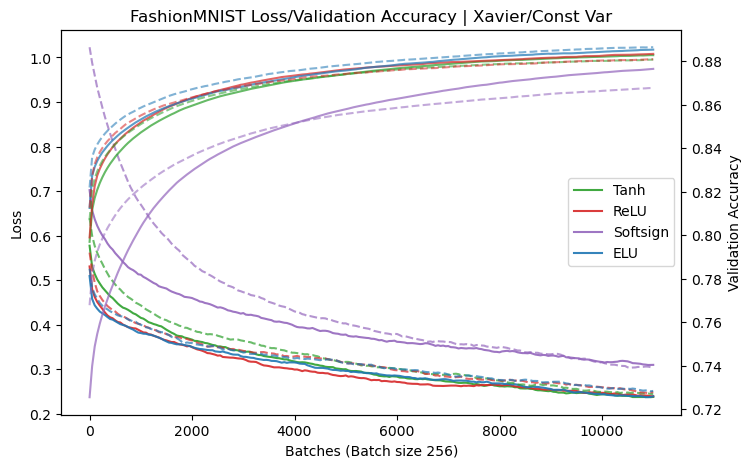

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))

window_size = 50
for activation_function, loss in const_var_losses_merged.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label=activation_function_mapper[str(activation_function)], color=activation_color_dict[activation_function], linestyle='-', alpha=0.9)
for activation_function, loss in xavier_losses_merged.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7)

valid_alpha = 0.8
ax_valid = ax.twinx()

for activation_function, loss in const_var_acc_merged.items():
    if activation_function != "sigmoid":
        ax_valid.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9*valid_alpha)
for activation_function, loss in xavier_acc_merged.items():
    if activation_function != "sigmoid":
        ax_valid.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7*valid_alpha)


ax_valid.set_ylabel("Validation Accuracy") # (Smoothed)
ax.set_ylabel("Loss") # (Smoothed)
ax.set_xlabel("Batches (Batch size 256)")
ax.legend(loc="center right")
plt.title("FashionMNIST Loss/Validation Accuracy | Xavier/Const Var")
plt.savefig("./FashionMNIST_loss_valid8.png")

In [2]:
const_var_losses = []
xavier_losses = []

xavier_acc = []
const_var_acc = []

for i in range(0, 5):
    prefix = "./XavierFashionMNIST_test/" + str(i) + "/"
    # Load in data
    with open(prefix + "xaver_tests_losses.json", "r") as f:
        xavier_losses.append(json.load(f))

    with open(prefix + "const_var_tests_losses.json", "r") as f:
        const_var_losses.append(json.load(f))

    with open(prefix + "xaver_tests_validation_acc.json", "r") as f:
        xavier_acc.append(json.load(f))

    with open(prefix + "const_var_tests_validation_acc.json", "r") as f:
        const_var_acc.append(json.load(f))


In [3]:
print(xavier_losses[0].keys()) # The items to plot

dict_keys(['sigmoid', 'tanh', 'relu', 'softsign', 'elu'])


In [4]:
def get_mean(data):
    return np.mean(data, axis=0)

def get_std(data):
    return np.std(data, axis=0)

window_size = 100

def window_data(data, moving_window_size=160):
    return np.convolve(data, np.ones(moving_window_size), 'valid') / moving_window_size

def window_data_axis(data, moving_window_size=160):
    new_data = []
    for i, d in enumerate(data):
        new_data.append(np.convolve(d, np.ones(moving_window_size), 'valid') / moving_window_size)
    return new_data

In [5]:
xavier_losses_means = {}
xavier_losses_std = {}

const_var_losses_means = {}
const_var_losses_std = {}

xavier_acc_means = {}
xavier_acc_std = {}

const_var_acc_means = {}
const_var_acc_std = {}

for activation_function in xavier_losses[0].keys():
    xavier_losses_values = [xavier_losses[i][activation_function] for i in range(len(xavier_losses))]
    xavier_losses_means[activation_function] = get_mean(xavier_losses_values)
    xavier_losses_std[activation_function] = get_std(xavier_losses_values)

    const_var_losses_values = [const_var_losses[i][activation_function] for i in range(len(xavier_losses))]
    const_var_losses_means[activation_function] = get_mean(const_var_losses_values)
    const_var_losses_std[activation_function] = get_std(const_var_losses_values)

    const_var_acc_values = [const_var_acc[i][activation_function] for i in range(len(xavier_losses))]
    const_var_acc_means[activation_function] = get_mean(const_var_acc_values)
    const_var_acc_std[activation_function] = get_std(const_var_acc_values)

    xavier_acc_values = [xavier_acc[i][activation_function] for i in range(len(xavier_losses))]
    xavier_acc_means[activation_function] = get_mean(xavier_acc_values)
    xavier_acc_std[activation_function] = get_std(xavier_acc_values)


In [47]:
activation_color_dict = {
    "sigmoid": "tab:orange",
    "tanh": "tab:green",
    "relu": "tab:red",
    "softsign": "tab:purple",
    "elu": "tab:blue",
}

activation_function_dict_names = {
    "relu": "ReLU",
    "tanh": "Tanh",
    "elu": "ELU",
    "sigmoid": "Sigmoid",
    "softsign": "SoftSign",
}

activation_color_dict_acc = {
    "sigmoid": "tab:orange",
    "tanh": "tab:green",
    "relu": "tab:red",
    "softsign": "tab:purple",
    "elu": "tab:blue",
}

single_col = "tab:purple"

activation_color_dict_const_var = {
    "sigmoid": "tab:orange",
    "tanh": "tab:orange",
    "relu": "tab:orange",
    "softsign": "tab:orange",
    "elu": "tab:orange",
}

activation_color_dict_xavier = {
    "sigmoid": single_col,
    "tanh": single_col,
    "relu": single_col,
    "softsign": single_col,
    "elu": single_col,
}



def window_data(values, moving_average_window_size=200):
    return np.convolve(values, np.ones(moving_average_window_size), 'valid') / moving_average_window_size

acc
acc
acc


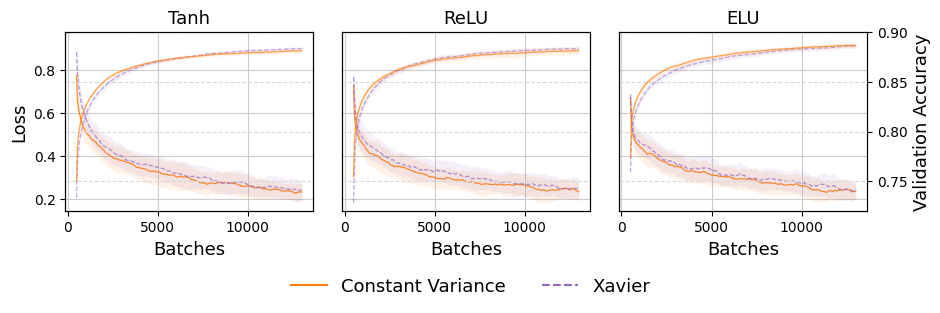

In [51]:
start = 1
stop = 4

include = ["tanh", "relu", "elu"]

plt.rcParams.update({
    "text.usetex": False,
})

plt.rcParams.update({'font.size': 14})
font_size = 13

plt.rc('font', size=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('axes', titlesize=font_size)

plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)

plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

plt.rc('axes', axisbelow=True)

fig, ax = plt.subplots(1, stop-start, figsize=(4.8*2, 0.96*1.5*2))
lw=0.9

tick_font_size = 8

window_size = 20
valid_window_size = 4
ax[0].set_ylabel("Loss")

std_alpha = 0.1


##########################################################
##################### ACCURACY ###########################
##########################################################
valid_alpha = 0.8
ax_valid = [a.twinx() for a in ax]

cur_i = 0
#window_size = 4
for i, (activation_function, loss) in enumerate(const_var_acc_means.items()): #[start:stop]
    if activation_function not in include:
        continue
    print("acc")
    i = cur_i

    #ax_valid[i].set_zorder(1)
    ax_valid[i].set_yticks([0.75, 0.8, 0.85, 0.9])
    ax_valid[i].set_ylim([0.72, 0.9])
    ax_valid[i].grid(visible=True, which='both', color='0.85', linestyle='--', zorder=1)

    ax_valid[stop-start-1].set_ylabel("Validation Accuracy")
    ax_valid[i].sharey(ax_valid[0])
    if i + start != stop-1:
        ax_valid[i].label_outer()
        ax_valid[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(const_var_acc_std[activation_function], window_size)

    #ax_valid[i].set_zorder(10)
    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_const_var[activation_function], alpha=std_alpha, lw=0, zorder=10)
    ax_valid[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict_const_var[activation_function], linestyle='-', alpha=0.9*valid_alpha, lw=lw, zorder=10)
    #ax_valid[i].set_zorder(1)
    cur_i += 1

############################ HE ##########################
cur_i = 0
for i, (activation_function, loss) in enumerate(xavier_acc_means.items()):
    if activation_function not in include:
        continue
    i = cur_i
    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]

    means = window_data(loss, window_size)
    stds = window_data(xavier_acc_std[activation_function], window_size)

    #ax_valid[i].set_zorder(10)
    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_xavier[activation_function], alpha=std_alpha, lw=0)
    ax_valid[i].plot(x_axis, window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict_xavier[activation_function], linestyle='--', alpha=0.7*valid_alpha, lw=lw)
    #ax_valid[i].set_zorder(1)
    cur_i += 1

##########################################################
####################### LOSS #############################
##########################################################
cur_i = 0
for i, (activation_function, loss) in enumerate(const_var_losses_means.items()):
    if activation_function not in include:
        continue
    i = cur_i

    #ax[i].set_zorder(1)
    ax[i].grid(visible=True, which='both', color='0.8', linestyle='-') #0.65
    ax[i].set_title(activation_function_dict_names[activation_function])
    ax[i].set_xlabel("Batches")
    ax[i].sharey(ax[0])
    ax[i].set_xticks([0, 5_000, 10_000, 20_000, 30_000])

    if i != 0:
        ax[i].label_outer()
        ax[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(const_var_losses_std[activation_function], window_size)

    #ax[i].set_zorder(10)
    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_const_var[activation_function], alpha=std_alpha, lw=0, zorder=10)
    ax[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict_const_var[activation_function], linestyle='-', alpha=0.9, lw=lw, zorder=10)
    #ax[i].set_zorder(1)
    cur_i += 1

############################ HE ##########################
cur_i = 0
for i, (activation_function, loss) in enumerate(xavier_losses_means.items()):
    if activation_function not in include:
        continue
    i = cur_i

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(xavier_losses_std[activation_function], window_size)

    #ax[i].set_zorder(10)
    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_xavier[activation_function], alpha=std_alpha, zorder=10, lw=0)
    ax[i].plot(x_axis, means, label="Xavier: " +str(activation_function), color=activation_color_dict_xavier[activation_function], linestyle='--', alpha=0.7, lw=lw, zorder=10)
    #ax[i].set_zorder(1)
    cur_i += 1

labels = ["Constant Variance", "Xavier"]

red_patch = mpatches.Patch(color='red', label='The red data')
line1 = mlines.Line2D([], [], color='tab:orange', label='Constant Variance')
line2 = mlines.Line2D([], [], color='tab:purple', label='Xavier', linestyle="--")

#ax[0].set_zorder(5)
#ax_valid[0].set_zorder(1)

#left, bottom, width, height
fig.legend(handles=[line1, line2], loc="center",  bbox_to_anchor=(0.5, -0.03, 0, 0),  ncol=2, frameon=False)
fig.tight_layout()
fig.savefig("./Xavier_FashionMNIST_loss_acc_bottom_2.png", bbox_inches='tight', dpi=800)


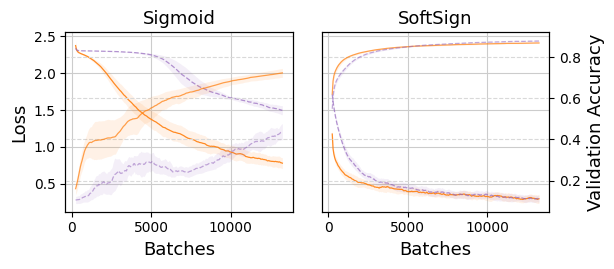

In [50]:
start = 1
stop = 3

include = ["sigmoid", "softsign"]

plt.rcParams.update({
    "text.usetex": False,
})

plt.rcParams.update({'font.size': 14})
font_size = 13

plt.rc('font', size=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('axes', titlesize=font_size)

plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)

plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

fig, ax = plt.subplots(1, stop-start, figsize=(4.8*2*0.66, 0.96*1.5*2))
lw=0.9

tick_font_size = 8

window_size = 10
valid_window_size = 4
ax[0].set_ylabel("Loss")

std_alpha = 0.1

##########################################################
####################### LOSS #############################
##########################################################
cur_i = 0
for i, (activation_function, loss) in enumerate(const_var_losses_means.items()):
    if activation_function not in include:
        continue
    i = cur_i

    ax[i].grid(visible=True, which='both', color='0.8', linestyle='-') #0.65
    ax[i].set_title(activation_function_dict_names[activation_function])
    ax[i].set_xlabel("Batches")
    ax[i].sharey(ax[0])
    ax[i].set_xticks([0, 5_000, 10_000, 20_000, 30_000])

    if i != 0:
        ax[i].label_outer()
        ax[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(const_var_losses_std[activation_function], window_size)

    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_const_var[activation_function], alpha=std_alpha, lw=0)
    ax[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict_const_var[activation_function], linestyle='-', alpha=0.9, lw=lw)

    cur_i += 1

############################ HE ##########################
cur_i = 0
for i, (activation_function, loss) in enumerate(xavier_losses_means.items()):
    if activation_function not in include:
        continue
    i = cur_i

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(xavier_losses_std[activation_function], window_size)

    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_xavier[activation_function], alpha=std_alpha, lw=0)
    ax[i].plot(x_axis, means, label="Xavier: " +str(activation_function), color=activation_color_dict_xavier[activation_function], linestyle='--', alpha=0.7, lw=lw)

    cur_i += 1


##########################################################
##################### ACCURACY ###########################
##########################################################
valid_alpha = 0.8
ax_valid = [a.twinx() for a in ax]

cur_i = 0

for i, (activation_function, loss) in enumerate(const_var_acc_means.items()): #[start:stop]
    if activation_function not in include:
        continue
    i = cur_i

    ax_valid[i].grid(visible=True, which='both', color='0.85', linestyle='--')
    ax_valid[stop-start-1].set_ylabel("Validation Accuracy")
    ax_valid[i].sharey(ax_valid[0])
    if i + start != stop-1:
        ax_valid[i].label_outer()
        ax_valid[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(const_var_acc_std[activation_function], window_size)

    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_const_var[activation_function], alpha=std_alpha, lw=0)
    ax_valid[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict_const_var[activation_function], linestyle='-', alpha=0.9*valid_alpha, lw=lw)
    cur_i += 1

############################ HE ##########################
cur_i = 0
for i, (activation_function, loss) in enumerate(xavier_acc_means.items()):
    if activation_function not in include:
        continue
    i = cur_i
    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(xavier_acc_std[activation_function], window_size)

    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict_xavier[activation_function], alpha=std_alpha, lw=0)
    ax_valid[i].plot(x_axis, window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict_xavier[activation_function], linestyle='--', alpha=0.7*valid_alpha, lw=lw)
    cur_i += 1

labels = ["Constant Variance", "He"]

red_patch = mpatches.Patch(color='red', label='The red data')
line1 = mlines.Line2D([], [], color='tab:orange', label='Constant Variance')
line2 = mlines.Line2D([], [], color='tab:purple', label='He', linestyle="--")

#left, bottom, width, height
fig.tight_layout()
fig.savefig("./Xavier_FashionMNIST_loss_acc_top_1.png", bbox_inches='tight', dpi=800)


In [54]:
# Generate the table for the paper

batch_numbers = [2500, 5000, 7500, 10_000, 100_000]

def get_results_for(loss, batch_numbers):
    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    indices = [np.argmin(np.abs(np.array(x_axis) - b)) for b in batch_numbers]
    return means[indices]

def get_result(x, valid=False):
    if valid:
        return np.median(x, axis=0)[0:213]
    else:
        return np.median(x, axis=0)[0:2000]

loss_values_const_var = {}
loss_values_he = {}

for i, (activation_function, loss) in enumerate(const_var_losses_means.items()):
    loss_values_const_var[activation_function] = get_results_for(loss, batch_numbers)

for i, (activation_function, loss) in enumerate(xavier_losses_means.items()):
    loss_values_he[activation_function] = get_results_for(loss, batch_numbers)

from decimal import Decimal

total_strings = []
for i, k in enumerate(loss_values_const_var.keys()):

    all_const_var = [str(round(Decimal(str(s)), 3)) for s in loss_values_const_var[k]]
    all_const_var =  all_const_var
    all_const_var = "&".join(all_const_var)

    all_he = [str(round(Decimal(str(s)), 3)) for s in loss_values_he[k]]
    all_he = "&".join(all_he)

    total_strings.append(
        " \multirow{2}*{" + k + "} & He &" + all_he + "\\\\" + "& Const Var &" + all_const_var + "\\\\")

total_string = "".join(total_strings)
print(total_string)

 \multirow{2}*{sigmoid} & He &2.292&2.244&1.891&1.666&1.510\\& Const Var &1.909&1.378&1.108&0.930&0.791\\ \multirow{2}*{tanh} & He &0.422&0.350&0.303&0.270&0.244\\& Const Var &0.397&0.327&0.275&0.261&0.235\\ \multirow{2}*{relu} & He &0.389&0.332&0.296&0.269&0.251\\& Const Var &0.367&0.302&0.274&0.265&0.235\\ \multirow{2}*{softsign} & He &0.603&0.448&0.375&0.349&0.304\\& Const Var &0.491&0.404&0.361&0.330&0.308\\ \multirow{2}*{elu} & He &0.380&0.334&0.296&0.279&0.246\\& Const Var &0.371&0.314&0.289&0.264&0.238\\
